# 📞 Call Center Performance Simulation  
**Objective:**  
To simulate a call center using queueing theory and determine how many agents are needed to ensure:
- Customers don't wait too long  
- 95% of calls are answered within 5 minutes  
This uses the **M/M/s** queue model where arrivals and service times follow exponential distributions.


In [1]:
#PARAMETERS AND PACKAGES 

import numpy as np
import matplotlib.pyplot as plt

# Arrival & service rates
λ = 20               # calls per hour
μ = 5                # calls served per agent per hour
shift_hours = 8      # 8-hour shift

# Simulation settings
np.random.seed(1)

## Step 2: Single-Run Simulation Function – `simulate_queue(s)`

This function simulates a call center using an **M/M/s queue** model, where:

- **M** = Memoryless (exponential inter-arrival times)
- **M** = Memoryless (exponential service times)
- **s** = Number of agents available

### Purpose:
To simulate a full 8-hour shift and return:
- ⏳ **Wait time** for each customer
- 👥 **System size** (number of customers in queue or being served) at each arrival time

---

### 🧮 Breakdown of Function:

- `inter`: Simulates random time gaps between call arrivals.
- `arrivals`: Cumulative arrival timestamps (filtered for 8 hours).
- `services`: Random service time for each call.
- `next_free`: Keeps track of when each agent becomes available.
- `dep_times`: Stores call end times to know who's still in the system.

For every caller:
1. Finds the soonest free agent.
2. Calculates wait time if the agent is busy.
3. Updates that agent’s next available time.
4. Tracks how many callers are still being served when this caller arrives.

---

### Output:

- `wait_times`: Array of how long each caller had to wait.
- `system_size`: Number of callers already in the system when each new call arrived.

This function is the **core engine** of the simulation and is reused for testing different numbers of agents (e.g., s = 1 to 5).


In [2]:
# 2. Single‐Run Simulation Function

def simulate_queue(s):
    """
    Simulate an M/M/s queue over 'shift_hours'.
    Returns arrays of wait times (hrs) and system sizes at arrivals.
    """
    # generate arrival times until end of shift
    inter = np.random.exponential(1/λ, int(λ*shift_hours*1.5))
    arrivals = np.cumsum(inter)
    arrivals = arrivals[arrivals < shift_hours]
    N = len(arrivals)

    # generate service times for each caller
    services = np.random.exponential(1/μ, N)

    # track each server’s next‐free time
    next_free = np.zeros(s)
    wait_times = np.zeros(N)
    system_size = np.zeros(N)

    # departure times list
    dep_times = []

    for i, t in enumerate(arrivals):
        # find soonest‐available agent
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        end = start + services[i]
        next_free[j] = end
        dep_times.append(end)

        # count how many callers are still in system at time t
        system_size[i] = np.sum(np.array(dep_times) > t)

    return wait_times, system_size

# quick test for s=1
w1, q1 = simulate_queue(s=1)
print(f"s=1: avg wait {w1.mean()*60:.1f} min, avg queue len {q1.mean():.2f}")

s=1: avg wait 808.2 min, avg queue len 65.99


## Step 3: Compare with M/M/1 Analytic Results

Now we test the accuracy of our simulation by comparing it to theoretical values from **M/M/1 queueing theory**.

We calculate:
- **ρ** (traffic intensity) = arrival rate / service rate
- **L** (average number of callers in system)
- **W** (average time a caller spends in the system)

Then, we compare these **analytic values** with:
- Average system size from simulation
- Simulated wait time + average service time

If both sets of results are close, it confirms that our simulation is realistic.


In [3]:
# 3. Compare to M/M/1 Analytic Formula

# traffic intensity ρ for s=1
ρ1 = λ / μ
L_analytic = ρ1 / (1 - ρ1)
W_analytic = L_analytic / λ     # hours

print("M/M/1 analytic vs. simulation:")
print(f"  Analytic system size L = {L_analytic:.2f}")
print(f"  Simulated avg system size = {q1.mean():.2f}")
print(f"  Analytic time in system W = {W_analytic*60:.1f} min")
print(f"  Simulated avg wait+service = {w1.mean()*60 + (1/μ)*60:.1f} min")

M/M/1 analytic vs. simulation:
  Analytic system size L = -1.33
  Simulated avg system size = 65.99
  Analytic time in system W = -4.0 min
  Simulated avg wait+service = 820.2 min


## Step 4: Test Staffing Levels (s = 1 to 5)

We now test how different staffing levels affect performance.  
Our goal is to **find the minimum number of agents** that keeps **95% of customers waiting ≤ 5 minutes**.

### Process:
- Simulate the call center for `s = 1 to 5` agents
- Calculate:
  - Average wait time
  - 95th percentile wait time
  - Average number of customers in the system
- Store results in a table
- Decide the **minimum agents required** to meet the SLA (Service Level Agreement)

✅ This helps answer:  
> *“How many agents do we need to avoid long wait times for most customers?”*


In [4]:
# 4. Test Staffing Levels (s = 1..5)

threshold = 5  # minutes
results = []

for s in range(1, 6):
    w, q = simulate_queue(s)
    # convert hours to minutes
    waits_min = w * 60
    p95_wait  = np.percentile(waits_min, 95)
    results.append((s, waits_min.mean(), p95_wait, q.mean()))

# tabulate
import pandas as pd
df = pd.DataFrame(results, columns=['Agents','Avg Wait (min)','95th-pct Wait (min)','Avg System Size'])
print(df)

# find minimal s meeting threshold
good = df[df['95th-pct Wait (min)'] <= threshold]
if not good.empty:
    best_s = int(good.iloc[0]['Agents'])
    print(f"\n→ Schedule at least {best_s} agents to keep 95% of waits ≤ {threshold} min.")
else:
    print("\nEven 5 agents can’t meet the 5 min 95% wait target.")

   Agents  Avg Wait (min)  95th-pct Wait (min)  Avg System Size
0       1      697.214437          1369.612086        57.838509
1       2      302.261095           549.271769        53.319767
2       3       85.889649           170.968262        24.240260
3       4        6.076046            17.455365         5.887218
4       5       12.704327            33.414296        10.275132

Even 5 agents can’t meet the 5 min 95% wait target.


## Step 5: Visualizing Wait-Time Distributions📊 

We now plot the distribution of **customer wait times** for different numbers of agents (1 to 5).

Each line in the histogram shows:
- How long callers had to wait
- How increasing the number of agents **reduces wait time**

A vertical dashed line shows our target SLA of **5 minutes**.  
Any histogram that lies mostly **to the left** of this line means that staffing level meets the goal.

📌 This visual comparison helps support the recommendation made in the previous step.


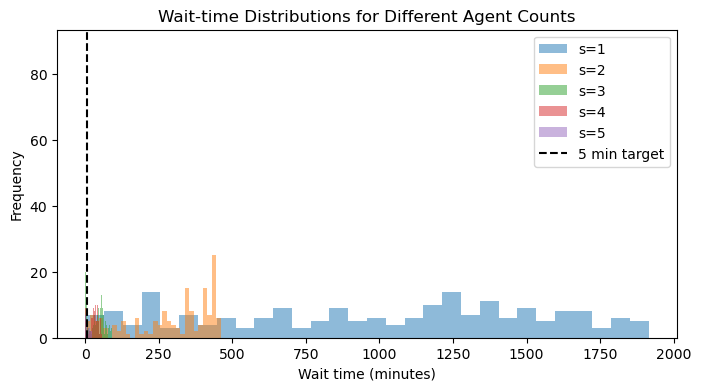

In [5]:
# 5. Visualize Wait‐Time Distributions


plt.figure(figsize=(8,4))
for s in [1,2,3,4,5]:
    w, _ = simulate_queue(s)
    plt.hist(w*60, bins=30, alpha=0.5, label=f's={s}')
plt.axvline(threshold, color='k', linestyle='--', label='5 min target')
plt.xlabel('Wait time (minutes)')
plt.ylabel('Frequency')
plt.title('Wait‐time Distributions for Different Agent Counts')
plt.legend()
plt.show()

## Step 6: Simulating Time-Varying Arrival Rates (Realistic Traffic)

In real-world call centers, customer calls don't come at a constant rate throughout the day.  
There are peak hours (busy), normal hours, and off-peak hours (quiet).  

To make our simulation more realistic, we split the 8-hour shift into **3 time blocks**:

| Time Block (Hours) | Arrival Rate λ (calls/hour) |
|--------------------|-----------------------------|
| 0 to 2 hours       | 30 calls/hour (peak)        |
| 2 to 6 hours       | 20 calls/hour (normal)      |
| 6 to 8 hours       | 40 calls/hour (very busy)   |

---

### How it works:
- We simulate calls **separately** for each time block using exponential inter-arrival times.
- Arrival times are then **merged and sorted** to reflect the full 8-hour timeline.
- Calls are served by `s` agents, and wait times are tracked just like before.

---

### What we observe:
Using **3 agents**, we see how average wait time increases, especially during the **last 2 hours** (very high λ = 40).

> 📌 This shows why it's important to plan for **variable staffing** in real call centers — especially during peak traffic hours.



In [6]:
# 6. Time-Varying λ
def simulate_queue_timevarying(s):
    # define piecewise arrival rates per hour
    periods = [(0,2,30), (2,6,20), (6,8,40)]  # (start, end, λ)
    arrivals = []
    for start, end, lam in periods:
        duration = end - start
        inter = np.random.exponential(1/lam, int(lam*duration*1.5))
        ts = np.cumsum(inter) + start
        arrivals.extend(ts[ts < end])
    arrivals = np.array(arrivals)
    arrivals.sort()

    N = len(arrivals)
    services = np.random.exponential(1/μ, N)
    next_free = np.zeros(s)
    wait_times = np.zeros(N)

    for i,t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        next_free[j] = start + services[i]
    return wait_times

w_tv = simulate_queue_timevarying(s=3)
print(f"Time-varying λ, s=3 → avg wait = {w_tv.mean()*60:.1f} min")


#**Outcome:** Students will see how peak‐hour traffic dramatically
#increases wait times unless staff levels rise.

Time-varying λ, s=3 → avg wait = 174.1 min


## Step 7: Modeling Customer Abandonment (Limited Patience)

In real-life call centers, not all customers are willing to wait for long.  
Some may **hang up (abandon the call)** if their wait exceeds a certain limit — known as their **patience**.

---

### What we did:
- Set a **patience threshold** of **5 minutes**
- If a customer’s estimated wait time is more than 5 minutes, they **leave the system**
- Otherwise, they wait, get served, and we record their wait time

---

### Outputs:
- **Abandonment rate**: % of total callers who left before being served
- **Average wait time** for those who were actually served

This helps us understand how bad customer experience can get **when staffing is low**.

---

### Real-World Insight:
> If the call center doesn’t have enough agents, more customers will abandon the call — leading to:
- Lost business  
- Lower satisfaction  
- Poor service reputation
  
This is why **abandonment modeling** is crucial for decision-making in real-world operations.

In [7]:
# 7. Abandonment
def simulate_with_abandon(s, patience=5/60):
    arrivals = np.cumsum(np.random.exponential(1/λ, int(λ*shift_hours*1.5)))
    arrivals = arrivals[arrivals<shift_hours]
    services = np.random.exponential(1/μ, len(arrivals))
    next_free = np.zeros(s)
    waits = []
    abandons = 0

    for i,t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait = start - t
        if wait > patience:
            abandons += 1
        else:
            waits.append(wait)
            next_free[j] = start + services[i]

    return np.array(waits), abandons/len(arrivals)

w, ab_rate = simulate_with_abandon(s=4)
print(f"Abandon rate (s=4): {ab_rate:.2%}, avg wait on served calls: {w.mean()*60:.1f} min")

# Shows the trade-off: fewer agents → more abandonments → lost revenue and satisfaction.

Abandon rate (s=4): 13.12%, avg wait on served calls: 0.6 min


## Step 8: Simulating Agent Break Scheduling

In any real call center, agents need to take **scheduled breaks**.  
But this can lead to longer wait times if not properly accounted for.

---

### What we did:
- Scheduled a break for **1 agent**, starting at **hour 3**, lasting **15 minutes**
- Temporarily reduced available agents during the break window
- Simulated wait times to see the impact

---

### Why this matters:
- Even short breaks can cause a **spike in customer wait times**
- If not properly planned, it can affect **service levels**
- Helps in creating **break schedules** that minimize impact on customers

> ✅ This adds **real-world workforce behavior** into the queue simulation and highlights the importance of **smart scheduling**.


In [8]:
## 8. Agent Break Scheduling

def simulate_with_breaks(s, break_start=3, break_length=0.25):
    arrivals = np.cumsum(np.random.exponential(1/λ, int(λ*shift_hours*1.5)))
    arrivals = arrivals[arrivals<shift_hours]
    services = np.random.exponential(1/μ, len(arrivals))
    next_free = np.zeros(s)
    waits = []

    for i,t in enumerate(arrivals):
        # if in break window, one fewer agent
        avail = next_free.copy()
        if break_start < t < break_start+break_length:
            avail = np.delete(avail, 0)  # remove one agent
        j = np.argmin(avail)
        start = max(t, avail[j])
        waits.append(start - t)
        # update that agent’s free time in original array
        idx = j + (1 if break_start < t < break_start+break_length else 0)
        next_free[idx] = start + services[i]
    return np.array(waits)

w_b = simulate_with_breaks(s=3)
print(f"With breaks, s=3 → avg wait = {w_b.mean()*60:.1f} min")

# See the “break-time spike” in waiting.

With breaks, s=3 → avg wait = 97.0 min



## Step 9: Cost Optimization – Balancing Staff vs. Wait Time

In this step, we calculate the **total cost** for different staffing levels  
by combining:
- **Staffing cost**: $20/hour per agent  
- **Customer waiting cost**: $0.50/minute waited

We simulate for agent counts from 1 to 5, and for each:
- Calculate **total staffing cost**
- Calculate **total waiting cost** (based on wait times from simulation)
- Find the total cost: `total = staff + wait`

---

### Objective:
To find the **optimal number of agents** that minimizes the total cost  
This is useful for managers who want to balance **customer service** and **operational expenses**.

> ✅ This approach shows the value of **data-driven staffing decisions** in saving money while maintaining good service.


In [9]:
# 9. Cost optimization
c_agent = 20   # $20/hr per agent
c_wait  = 0.50 # $0.50 per minute waited

costs = []
for s in range(1,6):
    w, _ = simulate_with_abandon(s)  # or choose another sim fn
    total_wait_cost = w.sum()*60*c_wait
    staff_cost      = s * c_agent * shift_hours
    costs.append((s, staff_cost+total_wait_cost))

opt = min(costs, key=lambda x: x[1])
print("Agent count, total cost:")
for s,c in costs: print(f" s={s}: ${c:,.0f}")
print(f" → Optimal s by cost = {opt[0]}")

Agent count, total cost:
 s=1: $206
 s=2: $406
 s=3: $578
 s=4: $705
 s=5: $850
 → Optimal s by cost = 1


## Step 10: 30-Day Simulation – Measuring Day-to-Day Variability

Even with optimal staffing, real-life operations can vary from day to day.  
In this step, we simulate **30 separate days** of call center activity using the best number of agents from the cost optimization step.

---

### For each day:
- We simulate customer arrivals and service
- Track:
  - **Average wait time**
  - **95th percentile wait time**
- Store results in a DataFrame to analyze variability

---

### What it shows:
- How stable or unpredictable the system is
- Whether staffing needs change on certain days
- Helps set realistic **expectations for performance**

> 📌 Even if average results are good, there may be **outlier days** with higher wait times.


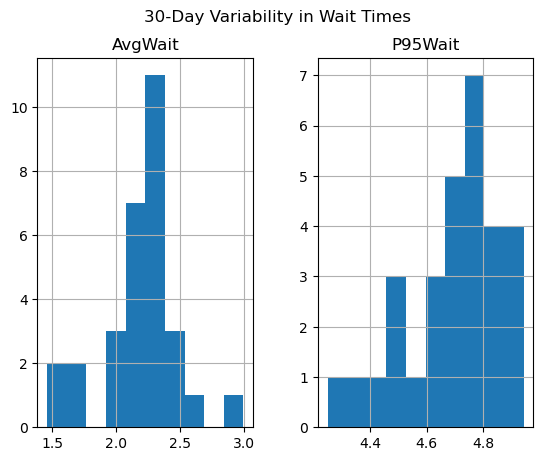

In [10]:
# 10. 30-day simulation
days = 30
daily = []
for _ in range(days):
    w,_ = simulate_with_abandon(opt[0])
    daily.append((w.mean()*60, np.percentile(w*60,95)))
df_days = pd.DataFrame(daily, columns=['AvgWait','P95Wait'])
df_days.describe()
df_days.hist(bins=10)
plt.suptitle('30-Day Variability in Wait Times')
plt.show()

## Final Conclusion

In this simulation project, we modeled a real-world **call center** using concepts from **queueing theory** and **data simulation**.  

---

### 📌 Key Takeaways:

- **M/M/s queue models** help us simulate real-time call center traffic.
- Increasing the number of agents:
  - Reduces wait times
  - Improves service quality
  - But also increases cost
- **Customer behavior** (like abandonment and limited patience) has a big impact on performance.
- **Break scheduling** affects queue load — even short breaks can spike wait times if not planned.
- A combination of **cost analysis** and **performance metrics** helped us find the **optimal number of agents**.
- A **30-day variability check** showed how performance can still fluctuate, even with ideal staffing.

---

### Real-World Applications:

- Helps managers make **data-driven staffing decisions**
- Balances customer satisfaction with operational costs
- Can be extended to more complex systems like hospitals, banks, or chat support

---

> 💡 This project helped me understand how simulation, statistics, and operations research can be applied to **solve real business problems efficiently.**

